<h1> <span style="color:red">Classify Song Genres from Audio Data </span> </h1>

## Réaliser par : 
 <ul>
<li><i> ibtissem BOUZIDI 3 DNI 2</i> </li>
<li> <i> Sbrine HOIYA 3 DNI 2 </i> </li>
    </ul>
    <center><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_449/img/iphone_music.jpg" alt="Project Image Record" width="200px"></center>

<div class="alert alert-block alert-danger"> <span style="color:#800000">Partie 1 </span> </div>

* **<span style="color:#0000C0">Dataset: </span>** Composé de chansons de deux genres musicaux (Hip-Hop et Rock).
* **<span style="color:#0000C0">Objectif: </span>**   parcourir cet ensemble de données et de classer les chansons (Spotify) en tant que « Hip-Hop » ou « Rock ».
* **<span style="color:#0000C0">Outils: </span>** Pandas, Seaborn, scikit-learn 
  

<div class="alert alert-block alert-danger"> <span style="color:#800000">Partie 2 </span> </div>

### 1/ Préparer notre jeu de données:
Charger les métadonnées de nos tracks avec les métriques de tracks compilées par l'EchoNest.

In [5]:
import pandas as pd

# Read in track metadata with genre labels
tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')
tracks.head(2)

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky


In [8]:
# Read in track metrics with the features
echonest_metrics = pd.read_json('datasets/echonest-metrics.json',precise_float = True)
echonest_metrics.head(4)

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590


In [12]:
# Merge the track_id and genre_top columns of tracks and echonest_metrics on track_id values
echo_tracks = pd.merge(left = tracks[['track_id', 'genre_top']], right=echonest_metrics, on='track_id')
echo_tracks.head(2)

,track_id,genre_top,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,153,Rock,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018
1,154,Rock,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,53.758,0.035632


In [11]:
# Inspect the resultant dataframe
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   genre_top         4802 non-null   object 
 2   acousticness      4802 non-null   float64
 3   danceability      4802 non-null   float64
 4   energy            4802 non-null   float64
 5   instrumentalness  4802 non-null   float64
 6   liveness          4802 non-null   float64
 7   speechiness       4802 non-null   float64
 8   tempo             4802 non-null   float64
 9   valence           4802 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


## 2/ Relations par paires entre variables continues:
Il faut éviter d'utiliser des variables qui ont de fortes corrélations les unes avec les autres, ainsi la redondance- pour plusieurs raisons:
<div class="alert alert-success"> <span style="color:#707000">
 <ul>
<li><i> Pour garder le modèle simple et améliorer l'interprétabilité (surapprentissage).</i> </li>
<li> <i>Lorsque nos Datasets sont très volumineux, l'utilisation de moins de fonctionnalités peut considérablement accélérer notre temps de calcul.</i> </li>
    </ul>
 </span></div>


In [13]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


<span style="color:orange"><b>Ici, nous pouvons voir une corrélation intéressante entre danceability et valence, mais elle n'est pas assez forte.</b></span>

## 3/ Normaliser les données
&#9888; &#x26A0; Simplifier nos modèles et les fonctionnalités nécessaire pour obtenir le meilleur résultat.<br>
&#x2611; Utiliser une approche pour réduire le nombre de caractéristiques appelée Analyse en Composantes Principales (ACP) est une méthode de <code>dimensionality reduction</code>.

* <span style="color:red"><b>Probleme:</b></span><br>
<i>PCA utilise la variance absolue d'une caractéristique pour faire pivoter les données, une caractéristique avec une plage de valeurs plus large dominera et biaisera l'algorithme par rapport aux autres caractéristiques</i> <br>
* <span style="color:#0000C0"><b>Solution:</b></span><br>
<i>Il existe plusieurs méthodes, mais une méthode courante consiste à utiliser la standardisation , de sorte que toutes les caractéristiques aient une moyenne = 0 et un écart type = 1. </i>

In [35]:
# Define our features 
features = echo_tracks.drop(['genre_top', 'track_id'], axis = 1)
# Define our labels
labels = echo_tracks['genre_top']
# Import the StandardScaler
from sklearn.preprocessing import StandardScaler
# Scale the features and set the values to a new variable
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)
scaler.fit_transform(features)

array([[ 1.36170559, -0.98589622,  1.45332318, ..., -0.36415677,
        -1.07200261, -1.57310227],
       [ 1.31234237, -0.45568108, -2.46398518, ..., -0.49822414,
        -2.14506572, -1.5670495 ],
       [ 1.34364478, -1.60400213,  1.17609079, ..., -0.11890299,
        -1.022854  , -1.57194929],
       ...,
       [-1.29470431,  1.17682795,  0.13265633, ...,  0.85182206,
        -0.93541008, -0.07941825],
       [-1.13869115, -0.02253433,  0.57117905, ...,  1.40951543,
         1.31301348,  0.47513794],
       [-0.90611434,  1.10148973,  0.56322452, ...,  1.36030881,
        -1.43669053,  0.76217464]])

## 4/ Analyse en Composantes Principales sur nos données à l'échelle: 
Nous avons prétraité nos données, nous sommes prêts à utiliser la PCA pour déterminer de combien nous pouvons réduire la dimensionnalité de nos données. On utilise <strong>scree-plots</strong> et <strong>cumulative explained ratio plots</strong> 

In [36]:
# This is just to make plots appear in the notebook
%matplotlib inline
# Import our plotting module, and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_
exp_variance

array([0.24297674, 0.18044316, 0.13650309, 0.12994089, 0.11056248,
       0.08302245, 0.06923783, 0.04731336])

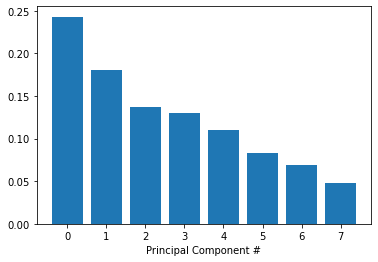

In [37]:
# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')
plt.show()

## 5/ Visualisation plus poussée de l'ACP:
<p>😣 Malheureusement, il ne semble pas y avoir de coude clair dans ce tracé, ce qui signifie qu'il n'est pas simple de trouver le nombre de dimensions intrinsèques à l'aide de cette méthode. Au lieu de cela, nous pouvons examiner le graphique de la variance expliquée cumulative pour déterminer combien de caractéristiques sont nécessairesdisons, environ 90 % de la variance.</p>

In [29]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)
cum_exp_variance

array([0.24297674, 0.4234199 , 0.55992299, 0.68986388, 0.80042636,
       0.88344881, 0.95268664, 1.        ])

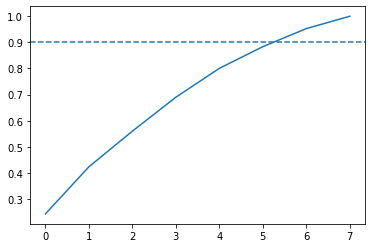

In [27]:
# Plot the cumulative explained variance and draw a dashed line at 0.90.
fig, ax = plt.subplots()
ax.plot(range(8),cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')
plt.show()

In [30]:
# choose the n_components where about 85% of our variance can be explained
n_components = 7

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

In [31]:
scaled_train_features.shape

(4802, 8)

In [32]:
pca_projection.shape

(4802, 7)